# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls

aguiar's_kernel.ipynb
data_visualize.ipynb
feature_matrix.csv
feature_selection-feature_by_kageyama-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection-feature_by_olivier-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection_feature_matrix_by_kageyama.ipynb
feature_selection_feature_matrix_by_olivier.ipynb
feature_selection_feature_matrix_noIDs_by_kageyama.ipynb
featuretools-for-Kageyama.ipynb
featuretools-for-aguiar.ipynb
featuretools-for-olivier.ipynb
featuretools.ipynb
kageyama-25CV_noIDs_delunimportant_98.ipynb
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant_794.csv
kageyama_feature_matrix_90.0.csv
kageyama_feature_matrix_92.0.csv
kageyama_feature_matrix_94.0.csv
kageyama_feature_matrix_96.0.csv
kageyama_feature_matrix_98.0.csv
lgbm_importances.png
lightGBM-5CV-first-subdata.ipynb
lightGBM-5CV-first.ipynb
lightGBM-feature_matrix_by_kageyama-random_grid_search.ipynb
lightGBM-oliver-random_grid_se

In [3]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_98.0.csv')
time.time() - st

81.35120296478271

In [4]:
df = df.drop('SK_ID_CURR', axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 23/23 [00:23<00:00,  1.04s/it]


36

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.757838	valid_1's auc: 0.751364
[200]	training's auc: 0.780621	valid_1's auc: 0.764733
[300]	training's auc: 0.797902	valid_1's auc: 0.774362
[400]	training's auc: 0.809489	valid_1's auc: 0.77959
[500]	training's auc: 0.818874	valid_1's auc: 0.78243
[600]	training's auc: 0.826857	valid_1's auc: 0.784164
[700]	training's auc: 0.834019	valid_1's auc: 0.78492
[800]	training's auc: 0.84052	valid_1's auc: 0.785498
[900]	training's auc: 0.846194	valid_1's auc: 0.786373
[1000]	training's auc: 0.851862	valid_1's auc: 0.787155
[1100]	training's auc: 0.85708	valid_1's auc: 0.787409
Early stopping, best iteration is:
[1067]	training's auc: 0.855349	valid_1's auc: 0.787606
Fold  1 AUC : 0.787606
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758014	valid_1's auc: 0.747944
[200]	training's auc: 0.780299	valid_1's auc: 0.76351
[300]	training's auc: 0.797787	valid_1's auc: 0.7

[1800]	training's auc: 0.88747	valid_1's auc: 0.788852
Early stopping, best iteration is:
[1740]	training's auc: 0.885067	valid_1's auc: 0.788981
Fold  8 AUC : 0.788981
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758447	valid_1's auc: 0.745825
[200]	training's auc: 0.780509	valid_1's auc: 0.758929
[300]	training's auc: 0.798008	valid_1's auc: 0.768661
[400]	training's auc: 0.809701	valid_1's auc: 0.773957
[500]	training's auc: 0.818996	valid_1's auc: 0.777193
[600]	training's auc: 0.826916	valid_1's auc: 0.778764
[700]	training's auc: 0.83383	valid_1's auc: 0.779691
[800]	training's auc: 0.840145	valid_1's auc: 0.780306
[900]	training's auc: 0.846225	valid_1's auc: 0.78093
[1000]	training's auc: 0.851665	valid_1's auc: 0.781522
[1100]	training's auc: 0.856694	valid_1's auc: 0.782044
[1200]	training's auc: 0.861444	valid_1's auc: 0.782576
[1300]	training's auc: 0.866249	valid_1's auc: 0.783392
[1400]	training's auc: 0.87094	valid_1's auc: 0.783

[800]	training's auc: 0.840466	valid_1's auc: 0.795136
[900]	training's auc: 0.846461	valid_1's auc: 0.795986
[1000]	training's auc: 0.85175	valid_1's auc: 0.796401
[1100]	training's auc: 0.856947	valid_1's auc: 0.796491
[1200]	training's auc: 0.86209	valid_1's auc: 0.796781
[1300]	training's auc: 0.866801	valid_1's auc: 0.79668
Early stopping, best iteration is:
[1232]	training's auc: 0.863544	valid_1's auc: 0.796895
Fold 16 AUC : 0.796895
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.757805	valid_1's auc: 0.75887
[200]	training's auc: 0.780255	valid_1's auc: 0.77334
[300]	training's auc: 0.797704	valid_1's auc: 0.784013
[400]	training's auc: 0.809406	valid_1's auc: 0.789439
[500]	training's auc: 0.818691	valid_1's auc: 0.792869
[600]	training's auc: 0.82645	valid_1's auc: 0.794509
[700]	training's auc: 0.833729	valid_1's auc: 0.796136
[800]	training's auc: 0.84014	valid_1's auc: 0.79705
[900]	training's auc: 0.846294	valid_1's auc: 0.797513
[1

[600]	training's auc: 0.826765	valid_1's auc: 0.792941
[700]	training's auc: 0.833847	valid_1's auc: 0.794679
[800]	training's auc: 0.840128	valid_1's auc: 0.795801
[900]	training's auc: 0.846205	valid_1's auc: 0.796572
[1000]	training's auc: 0.851767	valid_1's auc: 0.797189
[1100]	training's auc: 0.857045	valid_1's auc: 0.798068
[1200]	training's auc: 0.861885	valid_1's auc: 0.798548
[1300]	training's auc: 0.866508	valid_1's auc: 0.799101
[1400]	training's auc: 0.871013	valid_1's auc: 0.799325
[1500]	training's auc: 0.87545	valid_1's auc: 0.799454
[1600]	training's auc: 0.87972	valid_1's auc: 0.799746
[1700]	training's auc: 0.883827	valid_1's auc: 0.799821
[1800]	training's auc: 0.887634	valid_1's auc: 0.799905
[1900]	training's auc: 0.891394	valid_1's auc: 0.800061
[2000]	training's auc: 0.895033	valid_1's auc: 0.800157
Early stopping, best iteration is:
[1956]	training's auc: 0.893394	valid_1's auc: 0.800312
Fold 25 AUC : 0.800312
Full AUC score 0.793490


In [7]:
sub.to_csv('./kageyama_98_sub.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


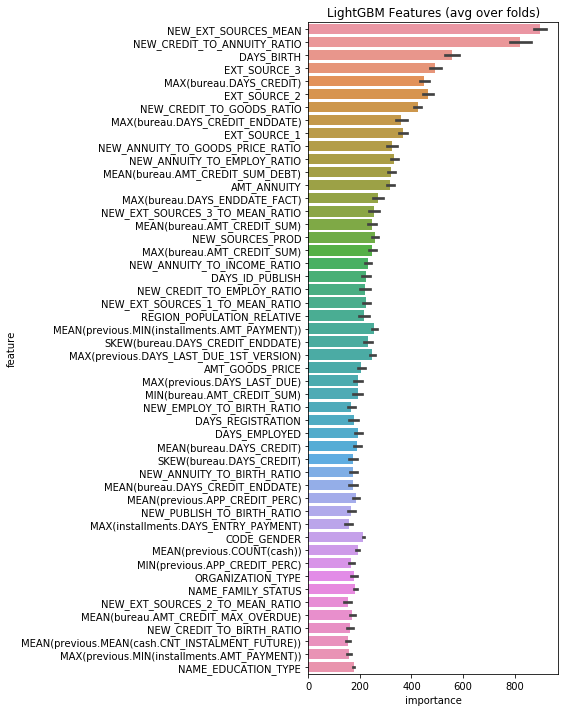

In [9]:
display_importances(feature_importance_df)

In [10]:
time.time() - st

14212.863361120224